In [1]:
from pybaseball import statcast, statcast_pitcher, pitching_stats, cache
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybaseball

import json
import os


pybaseball.cache.enable()
pd.set_option("display.max_columns", None)

## Data Creation and Preparation

In [2]:
columns = [
    'pitcher',
    'pitch_type',
    #'p_throws',
    # 'type',
    #'balls',
    #'strikes',
    #'on_3b',
    #'on_2b',
    #'on_1b',
    #'outs_when_up',
    #'inning',
    # 'inning_topbot',
    #'home_score',
    #'away_score',
    #'post_home_score',
    #'post_away_score',
    'release_speed',
    'release_pos_x',
    'release_pos_y',
    'release_pos_z',
    'vx0',
    'vy0',
    'vz0',
    'ax',
    'ay',
    'az',
    #'home_team',
    #'away_team'
]

In [3]:
def download():
    path = './full-sample.csv'
    if not os.path.isfile(path): 
        data = statcast(start_dt='2020-01-01', end_dt='2022-12-31')
        data.to_csv('full-sample.csv', index=False)
    data = pd.read_csv(path, usecols=columns)
    data = data[data['pitch_type'].notna()]
    return data


def is_nan_to_bool(value):
    if pd.isna(value):
        return False
    return True

def is_nan_to_zero(value):
    if pd.isna(value):
        return 0
    return value

def swap_dictionary_key_values(dictonary):
    return {v: k for k, v in dictonary.items()}

def list_to_dictionary(list_to_convert):
    d = dict(enumerate(list_to_convert))
    d = swap_dictionary_key_values(d)
    return d
    
def get_or_create_dictionary(df, dictionary_key):
    dictionary = {}
    base_path = './dictionaries'
    if not os.path.exists(base_path):
        os.mkdir(base_path) 
        
    if not os.path.isfile(f'{base_path}/{dictionary_key}.json'): 
        dictionary = list_to_dictionary(data[dictionary_key].unique())
        with open(f'{base_path}/{dictionary_key}.json', 'w') as convert_file:
            convert_file.write(json.dumps(dictionary))
    else:
        with open(f'{base_path}/{dictionary_key}.json') as json_file:
            dictionary = json.load(json_file)
    print(dictionary)        
    return dictionary

def load_dictionaries():
    teams_dict = get_or_create_dictionary(data,'home_team')
    pitch_types_dict = get_or_create_dictionary(data, 'pitch_type')
    p_throws_dict = get_or_create_dictionary(data,'p_throws')
    result_types_dict = get_or_create_dictionary(data,'type')
    inning_topbot_dict = get_or_create_dictionary(data,'inning_topbot')
    return teams_dict, pitch_types_dict, p_throws_dict, result_types_dict, inning_topbot_dict


data = download()

#data['on_3b'] = data['on_3b'].apply(is_nan_to_bool)
#data['on_2b'] = data['on_2b'].apply(is_nan_to_bool)
#data['on_1b'] = data['on_1b'].apply(is_nan_to_bool)
data = data.iloc[::-1]

teams_dict, pitch_types_dict, p_throws_dict, result_types_dict, inning_topbot_dict = load_dictionaries()

{'STL': 0, 'TB': 1, 'ARI': 2, 'NYM': 3, 'TEX': 4, 'MIL': 5, 'MIN': 6, 'OAK': 7, 'WSH': 8, 'CIN': 9, 'BOS': 10, 'LAD': 11, 'HOU': 12, 'BAL': 13, 'CWS': 14, 'PIT': 15, 'DET': 16, 'COL': 17, 'SD': 18, 'LAA': 19, 'PHI': 20, 'SF': 21, 'SEA': 22, 'CHC': 23, 'KC': 24, 'NYY': 25, 'MIA': 26, 'CLE': 27, 'TOR': 28, 'ATL': 29}
{'FF': 0, 'SI': 1, 'SL': 2, 'CH': 3, 'FC': 4, 'CU': 5, 'FS': 6, 'KC': 7, 'FO': 8, 'PO': 9, 'EP': 10, 'KN': 11, 'SC': 12, 'FA': 13, 'CS': 14, 'FT': 15}
{'R': 0, 'L': 1}
{'B': 0, 'S': 1, 'X': 2}
{'Top': 0, 'Bot': 1}


In [4]:
def missing_columns(df, threshold = 70, n = None):
    dff = df.isnull().sum()/df.shape[0] * 100
    dff = dff.reset_index()
    dff.columns = ['col', 'missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > threshold].shape[0]} columns with missing percent values greater than {threshold}%')
    if n:
        return dff.head(n)
    else:
        return dff

def unique_value_column(df):
    for col in df.columns:
        shape = df[col].value_counts().shape[0]
        missing = round(df[col].isnull().sum()/df.shape[0] * 100, 2)
        print(f'No of unique values in {col} is {shape} | missing percent is {missing}%')

In [5]:
missing_columns(data)

There are 10 columns in this dataset with missing values.
There are 0 columns with missing percent values greater than 70%


,col,missing_percent
0,release_pos_x,0.006291
1,release_pos_z,0.006291
2,release_pos_y,0.006291
3,release_speed,0.001661
4,vx0,0.001007
5,vy0,0.001007
6,vz0,0.001007
7,ax,0.001007
8,ay,0.001007
9,az,0.001007


In [6]:
unique_value_column(data)

No of unique values in pitch_type is 16 | missing percent is 0.0%
No of unique values in release_speed is 687 | missing percent is 0.0%
No of unique values in release_pos_x is 1074 | missing percent is 0.01%
No of unique values in release_pos_z is 703 | missing percent is 0.01%
No of unique values in pitcher is 1971 | missing percent is 0.0%
No of unique values in vx0 is 3973926 | missing percent is 0.0%
No of unique values in vy0 is 3973927 | missing percent is 0.0%
No of unique values in vz0 is 3973926 | missing percent is 0.0%
No of unique values in ax is 3973927 | missing percent is 0.0%
No of unique values in ay is 3973927 | missing percent is 0.0%
No of unique values in az is 3973926 | missing percent is 0.0%
No of unique values in release_pos_y is 592 | missing percent is 0.01%


In [7]:
data.head(60)
data.to_csv('essential-columns.csv', index=False)

In [8]:
data = pd.read_csv('essential-columns.csv')
#data['home_team'] = data['home_team'].apply(lambda x: teams_dict[x])
#data['away_team'] = data['away_team'].apply(lambda x: teams_dict[x])
data['pitch_type'] = data['pitch_type'].apply(lambda x: pitch_types_dict[x])
#data['p_throws'] = data['p_throws'].apply(lambda x: p_throws_dict[x])
#data['type'] = data['type'].apply(lambda x: result_types_dict[x])
#data['inning_topbot'] = data['inning_topbot'].apply(lambda x: inning_topbot_dict[x])

In [9]:
data.head(25)

,pitch_type,release_speed,release_pos_x,release_pos_z,pitcher,vx0,vy0,vz0,ax,ay,az,release_pos_y
0,0,94.9,-1.33,5.59,593372,5.773372,-137.729770,0.007950,-10.848010,29.457908,-18.784685,55.07
1,1,95.9,-1.31,5.48,593372,5.288673,-139.217803,-4.486852,-21.233172,30.974374,-20.788933,55.07
2,1,97.3,-1.32,5.18,593372,6.353246,-141.192269,-5.944415,-18.881798,30.681296,-23.942620,54.80
3,2,84.6,-1.25,5.39,593372,1.149067,-122.821485,-1.341576,10.331882,24.074272,-33.798336,55.68
4,1,98.4,-1.23,5.15,593372,7.179546,-142.581131,-4.918857,-18.573869,33.201434,-22.306689,54.92
5,1,96.3,-1.36,5.24,593372,7.776288,-139.561217,-2.631489,-17.117458,32.702018,-23.124852,54.86
6,2,86.6,-1.30,5.51,593372,5.831739,-125.415532,-4.837204,12.917047,27.577018,-24.854894,55.39
7,2,86.1,-1.25,5.23,593372,1.492227,-124.952085,-2.013251,10.461457,24.948835,-32.384709,55.58
8,0,99.9,-1.09,5.34,593372,3.394065,-144.892140,-2.830015,-12.444291,35.141691,-15.539013,54.88
9,0,99.3,-0.80,5.45,593372,3.599811,-144.046272,-1.319020,-13.325387,35.529831,-15.686738,54.71


In [12]:
get_files = True
if not get_files:
    pitchers = data['pitcher'].unique()
    base_path = './pitchers'
    if not os.path.exists(base_path):
        os.mkdir(base_path)

    for pitcher in pitchers:
        path = f'{base_path}/{pitcher}.csv'
        df = data[data['pitcher'] == pitcher]
        df = df.drop(['pitcher'], axis='columns')

        df['release_pos_x'] = df['release_pos_x'].apply(is_nan_to_zero)
        df['release_pos_z'] = df['release_pos_z'].apply(is_nan_to_zero)
        df['release_pos_y'] = df['release_pos_y'].apply(is_nan_to_zero)
        df['release_speed'] = df['release_speed'].apply(is_nan_to_zero)
        df['vx0'] = df['vx0'].apply(is_nan_to_zero)
        df['az'] = df['az'].apply(is_nan_to_zero)
        df['ay'] = df['ay'].apply(is_nan_to_zero)
        df['ax'] = df['ax'].apply(is_nan_to_zero)
        df['vz0'] = df['vz0'].apply(is_nan_to_zero)
        df['vy0'] = df['vy0'].apply(is_nan_to_zero)

        #df['on_3b'] = df['on_3b'].apply(is_nan_to_bool)
        #df['on_2b'] = df['on_2b'].apply(is_nan_to_bool)
        #df['on_1b'] = df['on_1b'].apply(is_nan_to_bool)
        df.to_csv(path, index=False)
    

## Model Testing

In [13]:
import tensorflow as tf
import torch
torch.cuda.empty_cache()
import os
import pandas as pd
import sklearn
import numpy as np
from tsai.models.MINIROCKET_Pytorch import *
from tsai.models.utils import *
from tsai.all import *
import umap

computer_setup()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

C:\Users\Adrian\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


os              : Windows-10-10.0.22621-SP0
python          : 3.10.5
tsai            : 0.3.4
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.13.1+cu116
device          : 1 gpu (['NVIDIA GeForce GTX 1660 Ti'])
cpu cores       : 8
threads per cpu : 2
RAM             : 31.36 GB
GPU memory      : [6.0] GB


device(type='cuda', index=0)

In [14]:
from sklearn import preprocessing
def df_to_X_y2(df: pd.DataFrame, target_column, window_size = 5): 
    df_2 = df.drop(target_column, axis='columns')
    scaler = preprocessing.StandardScaler().fit(df_2)
    df_as_np = scaler.transform(df_2)
    # df_as_np = df_2.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i + window_size]]
        X.append(row)
        label = df.iloc[i + window_size][target_column]
        y.append(label)
    return np.array(X), np.array(y)


def df_to_X_y2V2(df: pd.DataFrame, target_column, window_size = 5): 
    df_2 = df.drop(target_column, axis='columns')
    scaler = preprocessing.StandardScaler().fit(df_2)
    df_as_np = scaler.transform(df_2)
    #df_as_np = df_2.to_numpy()
    X = []
    y = []
    n_features = len(df_as_np[0,:])
    for i in range(len(df_as_np) - window_size):
        observation = []
        rows = df_as_np[i:i + window_size, :] 
        for f in range(0, n_features):
            observation.append(rows[:, f])
  
        X.append(observation)        
        label = df.iloc[i + window_size][target_column]
        y.append(label)
    return np.array(X), np.array(y)



In [15]:
# test = pd.read_csv('./prueba.csv')
# X, y = df_to_X_y2V2(test, 'y', 3)
# y

In [16]:
data = pd.read_csv('essential-columns.csv')
teams_dict, pitch_types_dict, p_throws_dict, result_types_dict, inning_topbot_dict = load_dictionaries()

{'STL': 0, 'TB': 1, 'ARI': 2, 'NYM': 3, 'TEX': 4, 'MIL': 5, 'MIN': 6, 'OAK': 7, 'WSH': 8, 'CIN': 9, 'BOS': 10, 'LAD': 11, 'HOU': 12, 'BAL': 13, 'CWS': 14, 'PIT': 15, 'DET': 16, 'COL': 17, 'SD': 18, 'LAA': 19, 'PHI': 20, 'SF': 21, 'SEA': 22, 'CHC': 23, 'KC': 24, 'NYY': 25, 'MIA': 26, 'CLE': 27, 'TOR': 28, 'ATL': 29}
{'FF': 0, 'SI': 1, 'SL': 2, 'CH': 3, 'FC': 4, 'CU': 5, 'FS': 6, 'KC': 7, 'FO': 8, 'PO': 9, 'EP': 10, 'KN': 11, 'SC': 12, 'FA': 13, 'CS': 14, 'FT': 15}
{'R': 0, 'L': 1}
{'B': 0, 'S': 1, 'X': 2}
{'Top': 0, 'Bot': 1}


In [17]:
test_df = pd.read_csv('./pitchers/645261.csv')
#test_df.on_3b = test_df.on_3b.replace({True: 1, False: 0})
#test_df.on_2b = test_df.on_2b.replace({True: 1, False: 0})
#test_df.on_1b = test_df.on_1b.replace({True: 1, False: 0})
#X, y = df_to_X_y2V2(test_df, 'pitch_type', 100)
#test_df.head()

In [18]:
reducer = umap.UMAP()
dto = test_df.drop('pitch_type', axis='columns')
embedding = reducer.fit_transform(dto)
embedding.shape

df = pd.DataFrame(data = embedding, 
                  columns = ['v1', 'v2'])
df['pitch_type'] = test_df['pitch_type']
X, y = df_to_X_y2V2(df, 'pitch_type', 100)
X.shape

(11158, 2, 100)

In [19]:
type(X.shape[1]), type(X.shape[2])

(int, int)

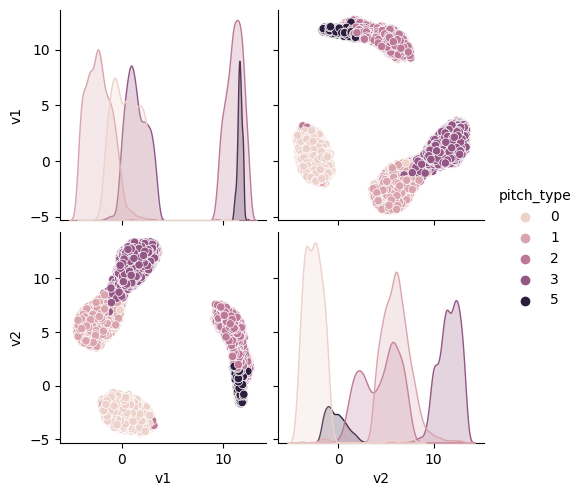

In [20]:
sns.pairplot(df, hue='pitch_type')

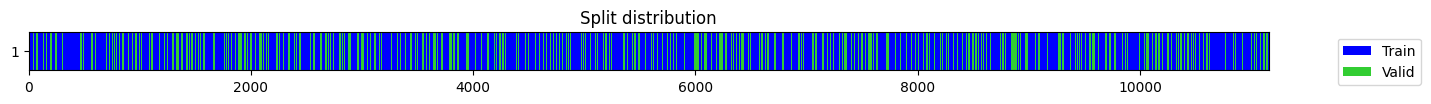

((#7811) [7339,7200,1945,10617,6196,5209,9868,10189,11084,3405...],
 (#3347) [9079,2327,8820,5572,9733,4836,7110,3367,5403,8606...])

In [21]:
splits = get_splits(y, valid_size=.3, stratify=True, random_state=231, shuffle=True)
splits

In [23]:
mrf = MiniRocketFeatures(X.shape[1], X.shape[2]).to(device)
X_train = X[splits[0]]
X_train = torch.from_numpy(X_train).float().to(device)
mrf.fit(X_train)
X_feat = get_minirocket_features(torch.from_numpy(X).float().to(device), mrf, to_np=True)
X_feat.shape, type(X_feat)

((11158, 9996, 1), numpy.ndarray)

In [24]:
PATH = Path("./models/MRF.pt")
PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(mrf.state_dict(), PATH)

In [25]:
# Using tsai/fastai, create DataLoaders for the features in X_feat.
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_feat, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
                 
# model is a linear classifier Head
model = build_ts_model(MiniRocketHead, dls=dls)
model

MiniRocketHead(
  (backbone): Sequential()
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): BatchNorm1d(9996, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=9996, out_features=5, bias=True)
  )
)

SuggestedLRs(valley=1.2022644114040304e-05)

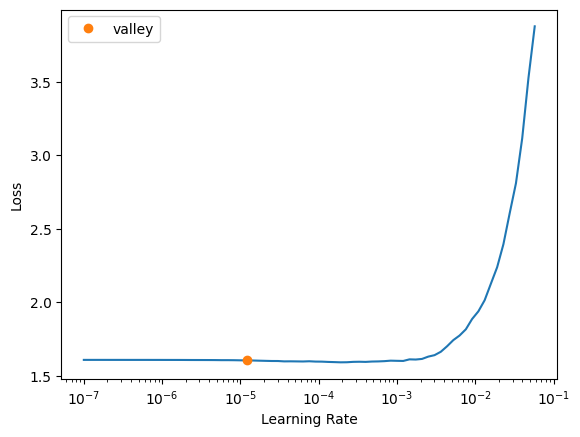

In [26]:
# Using tsai/fastai, create DataLoaders for the features in X_feat.
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_feat, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
                 
# model is a linear classifier Head
model = build_ts_model(MiniRocketHead, dls=dls)
                 
# Drop into fastai and use it to find a good learning rate.
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraph())
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.594873,1.580352,0.294592,00:01
1,1.564478,1.556683,0.324470,00:01
2,1.538699,1.541812,0.327756,00:01
3,1.527009,1.536451,0.336421,00:01
4,1.509121,1.530424,0.336719,00:01
5,1.494616,1.528829,0.332537,00:01
6,1.485041,1.526890,0.335823,00:01
7,1.475450,1.525797,0.339110,00:01
8,1.473093,1.525650,0.334329,00:01
9,1.472709,1.526003,0.336719,00:01


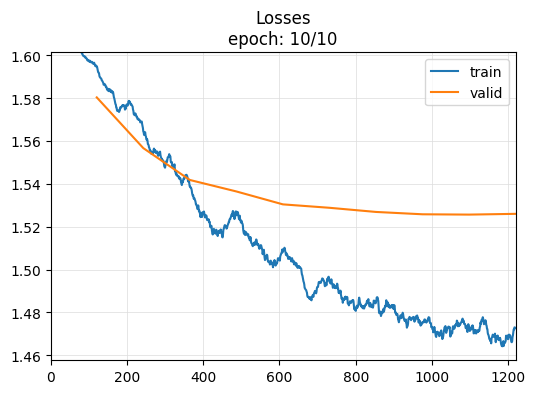

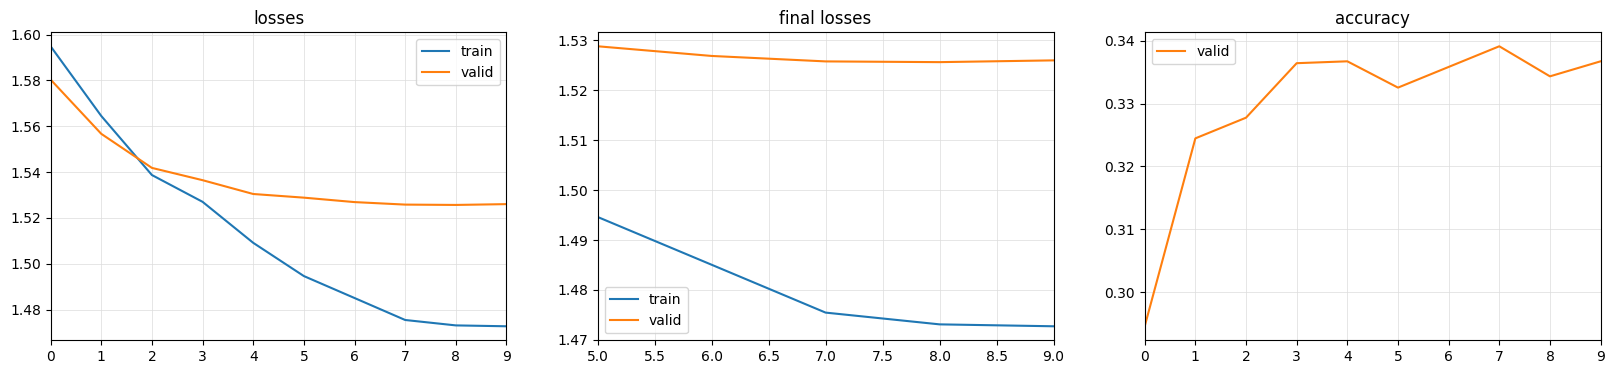

Total time              : 14.052323


14.052323

In [27]:
# As above, use tsai to bring X_feat into fastai, and train.
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X_feat, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
model = build_ts_model(MiniRocketHead, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraph())
timer.start()
learn.fit_one_cycle(10, 1.2022644114040304e-05)
timer.stop()

In [28]:
PATH = Path('./models/MRL.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)

### Inference

In [29]:
mrf = MiniRocketFeatures(X.shape[1], X.shape[2]).to(device)
PATH = Path("./models/MRF.pt")
mrf.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [30]:
new_feat = get_minirocket_features(torch.from_numpy(X[splits[1]]).float().to(device), mrf, chunksize=1024, to_np=True)
new_feat.shape, type(new_feat)

((3347, 9996, 1), numpy.ndarray)

In [31]:
PATH = Path('./models/MRL.pkl')
learn = load_learner(PATH, cpu=False)

In [32]:
probas, _, preds = learn.get_X_preds(new_feat)

In [33]:
sklearn.metrics.accuracy_score(y[splits[1]], preds.astype(np.float64))

0.3367194502539588